In [17]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import cv2
import numpy as np
from skimage import feature, segmentation
import argparse
import matplotlib.pyplot as plt


In [2]:
# Load the input image from the specified file path
def load_image(image_path):
    return cv2.imread(image_path)


In [3]:
# Preprocess the image to improve the quality of the detected contours
def preprocess_image(image):
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(grayscale_image, (5, 5), 0)
    ret, thresh_img = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return thresh_img

In [4]:
# Segment the binary image using watershed algorithm
def segment_image(image):
    distance = cv2.distanceTransform(image, cv2.DIST_L2, 5)
    local_max = feature.peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=image)
    markers = cv2.connectedComponents(local_max.astype(np.uint8))[1]
    markers = markers+1
    markers[image==0] = 0
    segmented = segmentation.watershed(-distance, markers, mask=image)
    return segmented.astype(np.uint8)


In [5]:
# Count the number of grains in the segmented image
def count_grains(image):
    label_count = len(np.unique(image))-1
    return image, label_count


In [6]:
def color_instances(image):
    # Generate a random color map with a unique color for each instance
    rng = np.random.RandomState(0)
    colors = rng.randint(0, 256, size=(np.max(image)+1, 3), dtype=np.uint8)
    colors[0, :] = 0 # Set the background color to black
    color_map = colors[image]

    # Create a mask for each instance in the labeled image
    masks = [(image == i).astype(np.uint8) for i in range(1, np.max(image)+1)]

    # Color each instance with a unique color
    colored_image = np.zeros_like(color_map)
    for i, mask in enumerate(masks):
        colored_mask = cv2.bitwise_and(color_map, color_map, mask=mask)
        colored_mask = colored_mask.astype(colored_image.dtype) # Cast colored_mask to the same data type as colored_image
        colored_image = (colored_image + colored_mask).astype(np.uint8)

    return colored_image

In [14]:
def main(image_path):
    # Load the input image
    image = load_image(image_path)

    # Preprocess the image
    binary_image = preprocess_image(image)

    # Segment the binary image using watershed algorithm
    labeled_image = segment_image(binary_image)

    # Count the number of grains in the segmented image
    labeled_image, grain_count = count_grains(labeled_image)

    # Color the instances of the labeled image
    colored_image = color_instances(labeled_image)

    # Concatenate the three images horizontally
    output_image = np.concatenate((image, cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR), colored_image), axis=1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Plot and display the input, binary and colored images
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    axs[0].imshow(image)
    axs[0].set_title('Input Image')
    axs[1].imshow(binary_image, cmap='gray')
    axs[1].set_title('Binary Image')
    axs[2].imshow(colored_image)
    axs[2].set_title('Segmentation Image')
    for ax in axs:
        ax.axis('off')

    # Save the output image
    output_path = 'output_image.jpg'
    cv2.imwrite(output_path, cv2.convertScaleAbs(output_image))

    # Print the grain count
    print(f'Number of grains detected: {grain_count}')

#     # Show the combined image with a title
#     plt.figure(figsize=(8, 4))
#     plt.imshow(output_image)
#     plt.title('Input, Binary and Colored Images')
#     plt.axis('off')
#     plt.show()

Number of grains detected: 255


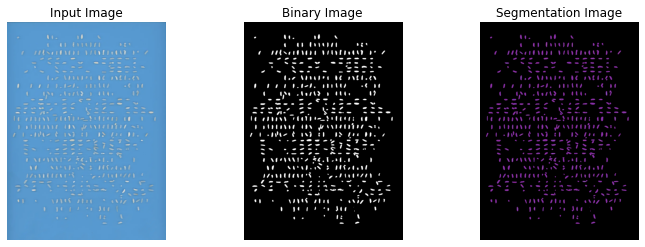

In [19]:
# Only call the main function if the script is run directly
if __name__ == '__main__':
    main("27.jpg")